In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

sns.set_theme()

In [44]:
# Set random seed for reproducibility
np.random.seed(42)

# Define paths
base_path_qualified = '/Users/iuliacostea/Desktop/FACTprojectGroup26/Table1_Experimental_Modified_Resumes/Reproducibility_Scores/Qualified'
base_path_unqualified = '/Users/iuliacostea/Desktop/FACTprojectGroup26/Table1_Experimental_Modified_Resumes/Reproducibility_Scores/Unqualified'

# Model names
model_names = ['Claude-Sonnet-4', 'DeepSeek-Chat', 'GPT-3.5-Turbo', 'Llama-3.3-70B', 'Mixtral-8x7B']

In [45]:
# Load original scores
unqualified_original = pd.read_csv(f'{base_path_unqualified}/ScoresDoorDash_PM_Original_first_260_UIUX.csv', index_col=0)
qualified_original = pd.read_csv(f'{base_path_qualified}/Original_PM_Qualified_CVs_Scored.csv', index_col=0)

# Sample 50 random indices from each
unqualified_sample_indices = unqualified_original.sample(n=50, random_state=42).index.tolist()
qualified_sample_indices = qualified_original.sample(n=50, random_state=42).index.tolist()

# Get sampled data
unqualified_sample = unqualified_original.loc[unqualified_sample_indices]
qualified_sample = qualified_original.loc[qualified_sample_indices]

# Create dataframe
scores_df = pd.DataFrame()
scores_df['No Manipulation'] = pd.concat([
    unqualified_sample.iloc[:, 0],
    qualified_sample.iloc[:, 0]
], ignore_index=True)

scores_df['True Label'] = [0]*50 + [1]*50

print(f"Loaded {len(scores_df)} CVs (50 unqualified + 50 qualified)")
print(f"Unqualified mean: {scores_df[scores_df['True Label']==0]['No Manipulation'].mean():.2f}")
print(f"Qualified mean: {scores_df[scores_df['True Label']==1]['No Manipulation'].mean():.2f}")

Loaded 100 CVs (50 unqualified + 50 qualified)
Unqualified mean: 79.17
Qualified mean: 81.15


In [46]:
# Load all model scores
for model_name in model_names:
    unqual_file = f'ScoresDoorDash_PM_Modified_{model_name.replace("-", "_")}_first_260_UIUX.csv'
    qual_file = f'ScoresDoorDash_PM_Modified_{model_name.replace("-", "_")}_last_260.csv'
    
    unqual_path = f'{base_path_unqualified}/{unqual_file}'
    qual_path = f'{base_path_qualified}/{qual_file}'
    
    if os.path.exists(unqual_path) and os.path.exists(qual_path):
        unqual_df = pd.read_csv(unqual_path, index_col=0)
        qual_df = pd.read_csv(qual_path, index_col=0)
        
        unqual_sample = unqual_df.loc[unqualified_sample_indices]
        qual_sample = qual_df.loc[qualified_sample_indices]
        
        scores_df[model_name] = pd.concat([
            unqual_sample.iloc[:, 0],
            qual_sample.iloc[:, 0]
        ], ignore_index=True)
        
        print(f"✓ {model_name} loaded")
    else:
        print(f"✗ {model_name} missing")

print("\nAll scores loaded!")

✓ Claude-Sonnet-4 loaded
✓ DeepSeek-Chat loaded
✓ GPT-3.5-Turbo loaded
✓ Llama-3.3-70B loaded
✓ Mixtral-8x7B loaded

All scores loaded!


Plot saved!


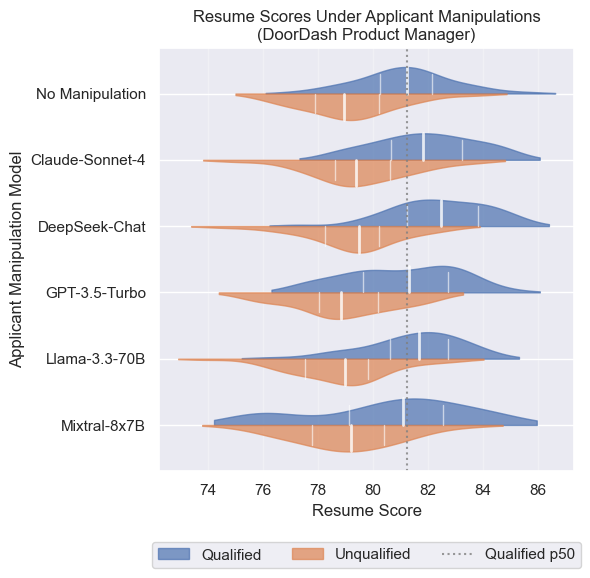

In [47]:
# Create horizontal split violin plot - manual approach
models_list = ['No Manipulation', 'Claude-Sonnet-4', 'DeepSeek-Chat', 'GPT-3.5-Turbo', 'Llama-3.3-70B', 'Mixtral-8x7B']

fig, ax = plt.subplots(figsize=(6, 6))

# Separate data by qualification status
qualified_df = scores_df[scores_df['True Label'] == 1][models_list].reset_index(drop=True)
unqualified_df = scores_df[scores_df['True Label'] == 0][models_list].reset_index(drop=True)

# Create positions for each model (on y-axis now)
positions = np.arange(len(models_list))

from scipy import stats as sp_stats

for i, model in enumerate(models_list):
    # Get data
    qual_data = qualified_df[model].values
    unqual_data = unqualified_df[model].values
    
    # Qualified (top half - blue)
    density_q = sp_stats.gaussian_kde(qual_data)
    xs_q = np.linspace(qual_data.min() - 1, qual_data.max() + 1, 200)
    density_q_vals = density_q(xs_q)
    # Normalize and scale
    density_q_vals = density_q_vals / density_q_vals.max() * 0.4
    
    # Unqualified (bottom half - orange)  
    density_u = sp_stats.gaussian_kde(unqual_data)
    xs_u = np.linspace(unqual_data.min() - 1, unqual_data.max() + 1, 200)
    density_u_vals = density_u(xs_u)
    # Normalize and scale
    density_u_vals = density_u_vals / density_u_vals.max() * 0.4
    
    # Plot qualified (top half) - horizontal orientation
    y_pos = len(models_list) - 1 - i  # Reverse order so first model is at top
    ax.fill_between(xs_q, y_pos, y_pos + density_q_vals, alpha=0.7, color='C0', label='Qualified' if i == 0 else '')
    
    # Plot unqualified (bottom half) - horizontal orientation
    ax.fill_between(xs_u, y_pos, y_pos - density_u_vals, alpha=0.7, color='C1', label='Unqualified' if i == 0 else '')
    
    # Add quartile lines
    quartiles_q = np.percentile(qual_data, [25, 50, 75])
    ax.plot([quartiles_q[1], quartiles_q[1]], [y_pos, y_pos + 0.4], color='white', linewidth=2, alpha=0.8)
    ax.plot([quartiles_q[0], quartiles_q[0]], [y_pos, y_pos + 0.3], color='white', linewidth=1, alpha=0.6)
    ax.plot([quartiles_q[2], quartiles_q[2]], [y_pos, y_pos + 0.3], color='white', linewidth=1, alpha=0.6)
    
    quartiles_u = np.percentile(unqual_data, [25, 50, 75])
    ax.plot([quartiles_u[1], quartiles_u[1]], [y_pos - 0.4, y_pos], color='white', linewidth=2, alpha=0.8)
    ax.plot([quartiles_u[0], quartiles_u[0]], [y_pos - 0.3, y_pos], color='white', linewidth=1, alpha=0.6)
    ax.plot([quartiles_u[2], quartiles_u[2]], [y_pos - 0.3, y_pos], color='white', linewidth=1, alpha=0.6)

# Format plot
qualified_median = scores_df[scores_df['True Label'] == 1]['No Manipulation'].median()
ax.axvline(x=qualified_median, color='gray', linestyle=':', alpha=0.8, label='Qualified p50')

# Reverse the models_list for y-axis labels
ax.set_yticks(positions)
ax.set_yticklabels(models_list[::-1])  # Reverse order
ax.set_ylabel('Applicant Manipulation Model')
ax.set_xlabel('Resume Score')
ax.set_title('Resume Scores Under Applicant Manipulations\n(DoorDash Product Manager)')
ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()

# Save plot
os.makedirs('img', exist_ok=True)
plt.savefig('img/doordash_pm_violin_plot.pdf')
plt.savefig('img/doordash_pm_violin_plot.png', dpi=300)
print('Plot saved!')
plt.show()

In [48]:
# Debug: Check the melted data structure
print("Checking data structure:")
print(f"Total rows in melted_df: {len(melted_df)}")
print(f"Qualified rows: {(melted_df['Ground Truth']=='Qualified').sum()}")
print(f"Unqualified rows: {(melted_df['Ground Truth']=='Unqualified').sum()}")
print(f"\nSample of melted data:")
print(melted_df.head(10))
print(f"\nScore ranges by group:")
for model in ['No Manipulation']:
    model_data = melted_df[melted_df['LLM'] == model]
    qual_scores = model_data[model_data['Ground Truth']=='Qualified']['Resume Score']
    unqual_scores = model_data[model_data['Ground Truth']=='Unqualified']['Resume Score']
    print(f"\n{model}:")
    print(f"  Qualified: {qual_scores.min():.2f} - {qual_scores.max():.2f} (n={len(qual_scores)})")
    print(f"  Unqualified: {unqual_scores.min():.2f} - {unqual_scores.max():.2f} (n={len(unqual_scores)})")

Checking data structure:
Total rows in melted_df: 1200
Qualified rows: 600
Unqualified rows: 600

Sample of melted data:
   True Label              LLM  Resume Score Ground Truth
0           0  No Manipulation        79.706  Unqualified
1           0  No Manipulation        78.910  Unqualified
2           0  No Manipulation        78.557  Unqualified
3           0  No Manipulation        83.853  Unqualified
4           0  No Manipulation        83.116  Unqualified
5           0  No Manipulation        76.527  Unqualified
6           0  No Manipulation        77.305  Unqualified
7           0  No Manipulation        81.646  Unqualified
8           0  No Manipulation        78.917  Unqualified
9           0  No Manipulation        79.815  Unqualified

Score ranges by group:

No Manipulation:
  Qualified: 76.08 - 85.62 (n=100)
  Unqualified: 74.69 - 85.28 (n=100)


In [49]:
# Print statistics
qualified = scores_df[scores_df['True Label'] == 1]
unqualified = scores_df[scores_df['True Label'] == 0]

print("="*80)
print("AVERAGE SCORES: QUALIFIED vs UNQUALIFIED")
print("="*80)
print(f"\n{'Model':<25} {'Qualified (n=50)':<20} {'Unqualified (n=50)':<20} {'Difference':<15}")
print("-"*80)

for model_name in models_list:
    qual_mean = qualified[model_name].mean()
    unqual_mean = unqualified[model_name].mean()
    diff = qual_mean - unqual_mean
    print(f"{model_name:<25} {qual_mean:>6.3f}              {unqual_mean:>6.3f}                {diff:>+6.3f}")

AVERAGE SCORES: QUALIFIED vs UNQUALIFIED

Model                     Qualified (n=50)     Unqualified (n=50)   Difference     
--------------------------------------------------------------------------------
No Manipulation           81.148              79.169                +1.979
Claude-Sonnet-4           81.904              79.595                +2.309
DeepSeek-Chat             82.423              79.315                +3.108
GPT-3.5-Turbo             81.034              78.968                +2.066
Llama-3.3-70B             81.429              78.861                +2.568
Mixtral-8x7B              80.525              79.054                +1.470
